## Remapping of an Image Hardware/Software Comparison

Setup for both hardware and software.

In [39]:
import cv2
import numpy as np
import PIL.Image
import time
# Load remap overlay
from pynq import Overlay
bareHDMI = Overlay("/usr/local/lib/python3.6/dist-packages/"
               "pynq_cv/overlays/xv2Filter2DRemap.bit")
import pynq_cv.overlays.xv2Filter2DRemap as xv2

# Load xlnk memory manager
from pynq import Xlnk
Xlnk.set_allocator_library("/usr/local/lib/python3.6/dist-packages/"
                           "pynq_cv/overlays/xv2Filter2DRemap.so")
mem_manager = Xlnk()

## Remap in software
Import image in greyscale, get its height and width, define a helper function for remapping, and display the input image.

1037 1383


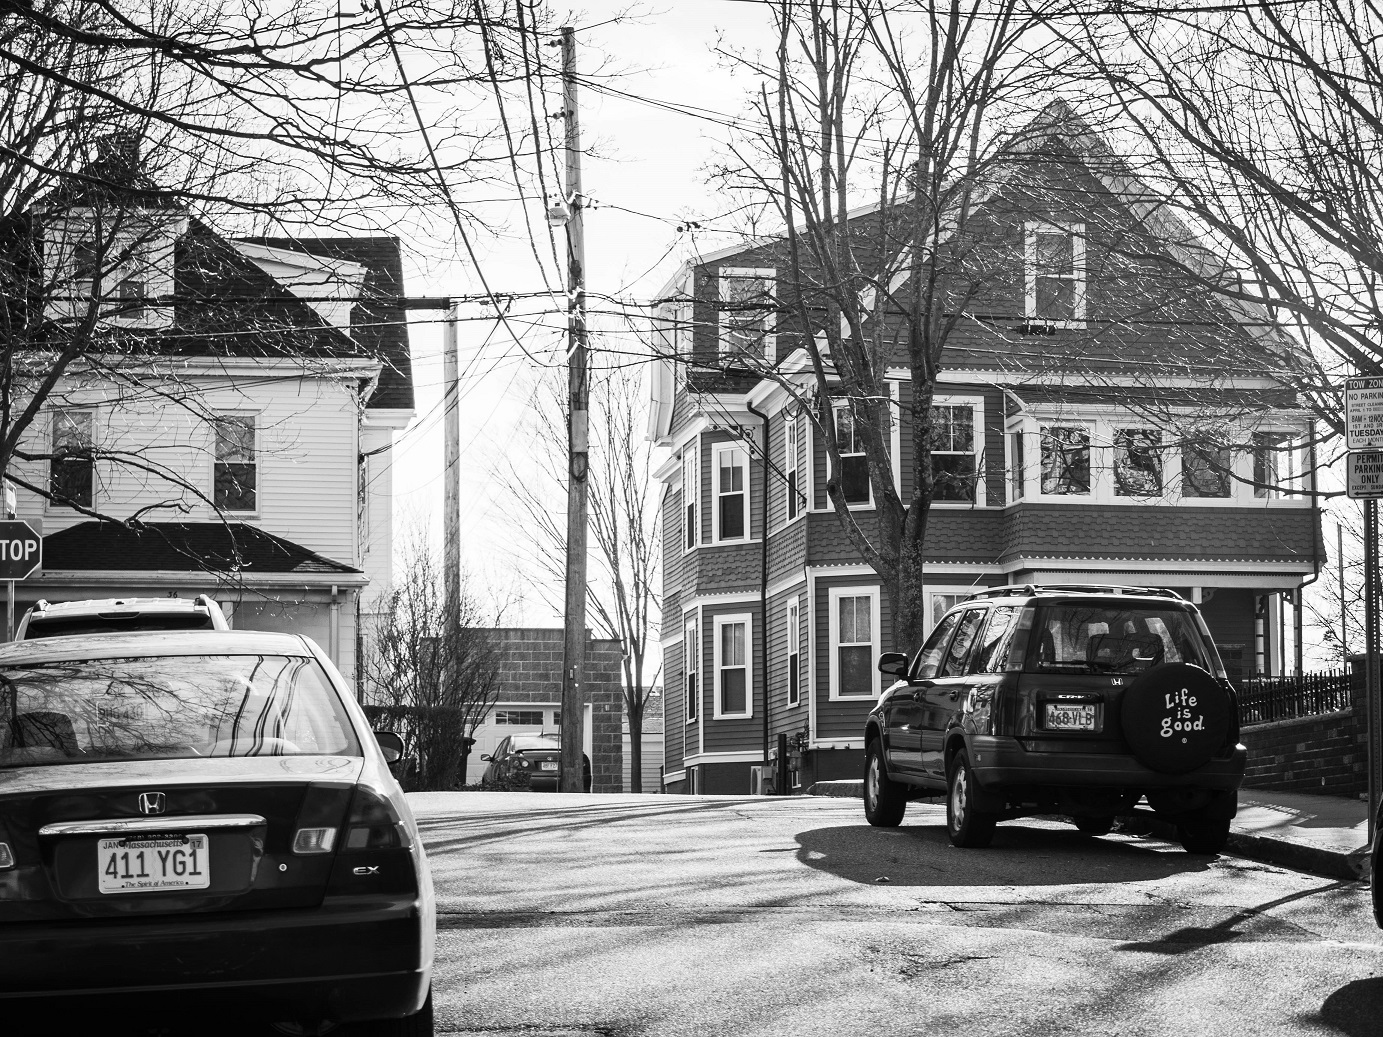

In [40]:
in_img = cv2.imread('a_photo_but_smaller.jpg', flags=0)
img_height, img_width = in_img.shape
# helper function that creates mapping for remap function
def makeMapCircleZoom(width, height, cx, cy, radius, zoom):
    mapY, mapX = np.indices((height,width),dtype=np.float32)
    
    for (j,i),x in np.ndenumerate(mapX[cy-radius:cy+radius,
                                       cx-radius:cx+radius]):
        x = i - radius
        y = j - radius
        i += cx-radius
        j += cy-radius
        mapX[(j,i)] = (cx + x/zoom) if (np.sqrt(x*x+y*y)<radius) else i
        mapY[(j,i)] = (cy + y/zoom) if (np.sqrt(x*x+y*y)<radius) else j

    return(mapX,mapY)
print(img_height, img_width)
PIL.Image.fromarray(in_img)

Choose and create a mapping for zoom circle (this part takes some time).

In [63]:
map1, map2 = makeMapCircleZoom(img_width,img_height,1379,440,135,2.0)

Run software remap on a single image and compute frame rate.

In [64]:
start = time.time()
out_img = cv2.remap(in_img, map1, map2, cv2.INTER_LINEAR)
end = time.time()
print("Frames per second:  " + str(1/(end-start)))

Frames per second:  7.177271226088192


Display the image remapped with a zoom circle.

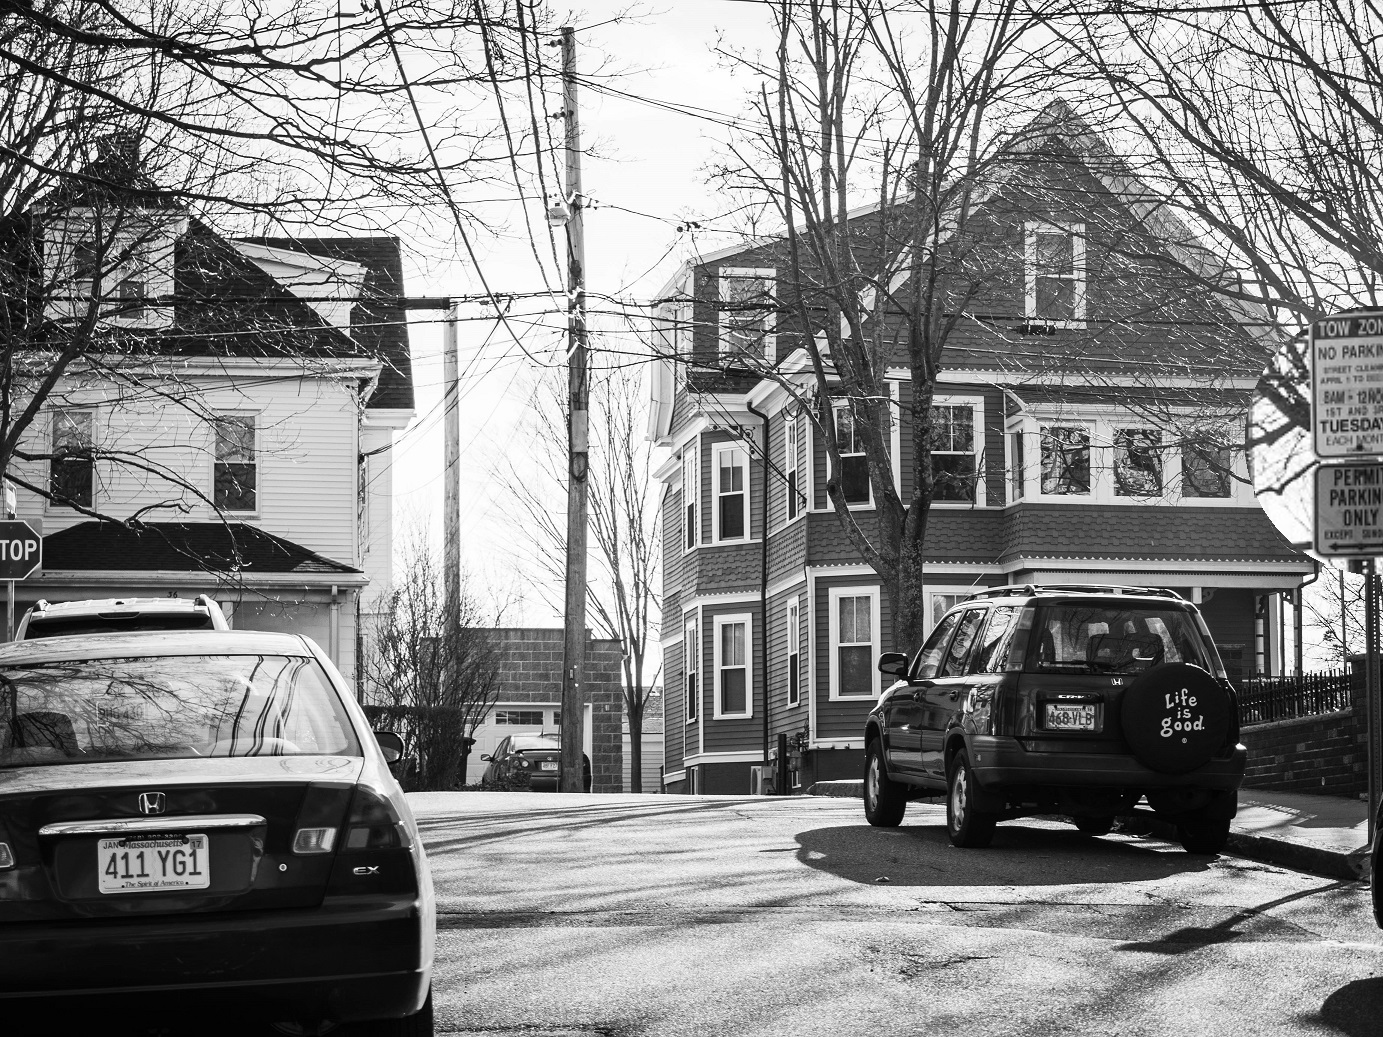

In [65]:
image = PIL.Image.fromarray(out_img)
image

## Hardware Remap
Remap in hardware using same map values and display the image along with fps.

Set up input and output buffers.

In [44]:
import pynq.buffer as pb

xv2_in = pb.allocate(in_img.shape, dtype=np.uint8)
xv2_out = pb.allocate(in_img.shape, dtype=np.uint8)

y, x = xv2_in.shape

for i in range(y):
    for j in range(x):
        xv2_in[i,j] = in_img[i,j]

xFmap1 = mem_manager.cma_array((img_height,img_width),np.float32)
xFmap2 = mem_manager.cma_array((img_height,img_width),np.float32)

xFmap1[:] = map1[:]
xFmap2[:] = map2[:]

Run HW remap, time it, calculate fps, and display the remapped image.

In [45]:
xv2_start=time.time()
xv2.remap(xv2_in, xFmap1, xFmap2, cv2.INTER_LINEAR, dst=xv2_out)
xv2_end=time.time()

print("Frames per second:  " + str(1 / (xv2_end - xv2_start)))

Frames per second:  54.38249098877162


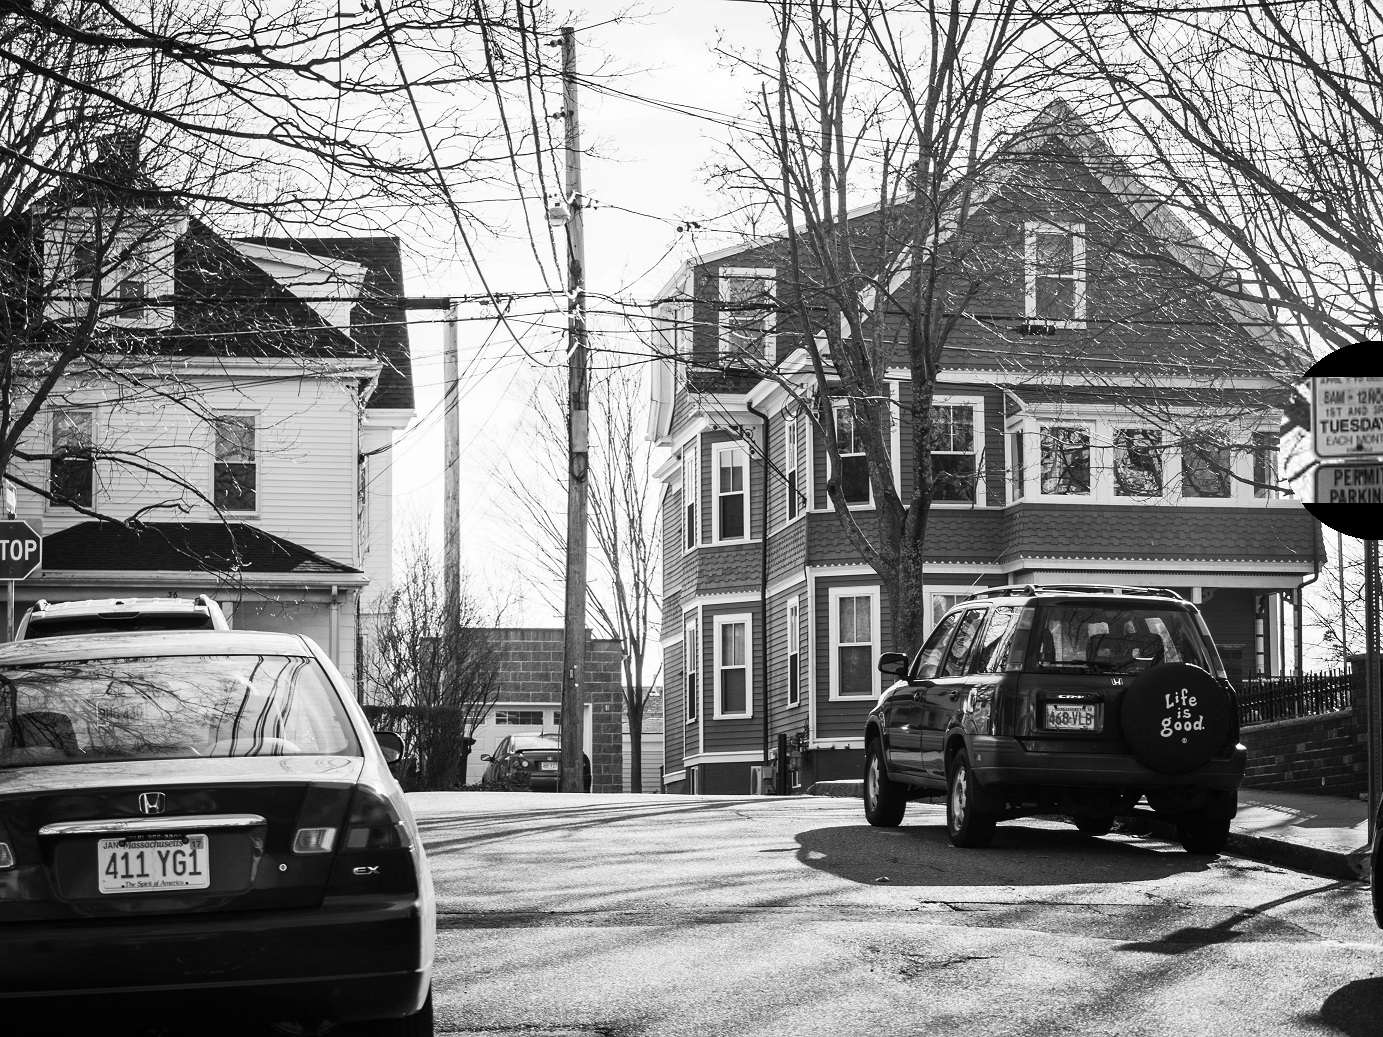

In [46]:
PIL.Image.fromarray(xv2_out)

## Remap Speed-up
Speed up of remap function in hardware calculated.

In [47]:
# calculate speed up
ps_fps = 1 / (end - start)
pl_fps = 1 / (xv2_end - xv2_start)
speed_up = pl_fps / ps_fps
print("PS fps: " + str(ps_fps) + "\nPL fps: " + str(pl_fps))
print("Speed up of %0.2fX achieved by PL" % speed_up)

PS fps: 6.6889786571022585
PL fps: 54.38249098877162
Speed up of 8.13X achieved by PL
